# Spanish Train Ticket Data Analysis

We have been asked by management to produce summary reports detailing general ridership reports that examine the volume of passengers, ticket prices paid, and length of trips taken by our customers. 

Some of these reports will be used internally by management, but the primary focus is producing a helpful webpage that gives customers a better idea of what the best travel times and fares are depending on their needs, which will reduce the amount of time our customer service agents spend explaining this information to customers. 

For now, we'll focus on trips between Madrid and Barcelona, our busiest route.

In [1]:
# import data manipulation libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

# import data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Task 1: Read in Data


First, read in the data provided, train_ticket.csv. Check the column data types, and change them if needed. 

In [2]:
train = pd.read_csv('train_ticket_data.csv',
                    parse_dates=['departure'],
                    dtype={
                        'origin':'category',
                        'destination':'category',
                        'vehicle_type':'category',
                        'vehicle-class':'category',
                        'fare':'category',
                    }
                    ).drop('Unnamed: 0', axis=1)

In [3]:
print(train.head())
print(train.info())

   origin destination           departure  duration vehicle_type  \
0  MADRID   BARCELONA 2019-05-18 20:30:00      3.17          AVE   
1  MADRID   BARCELONA 2019-05-18 06:20:00      3.15          AVE   
2  MADRID   BARCELONA 2019-05-18 07:30:00      3.17          AVE   
3  MADRID   BARCELONA 2019-05-18 07:30:00      3.17          AVE   
4  MADRID   BARCELONA 2019-05-18 09:30:00      3.07          AVE   

  vehicle_class  price   fare  
0  Turista Plus  69.80  Promo  
1       Turista  66.75  Promo  
2       Turista  85.10  Promo  
3       Turista  85.10  Promo  
4       Turista  85.10  Promo  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525950 entries, 0 to 1525949
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   origin         1525950 non-null  category      
 1   destination    1525950 non-null  category      
 2   departure      1525950 non-null  datetime64[ns]
 3   duration       15

## Task 2: New Columns and Missing Data Check

Then, create four columns and report on the percentage of missing values in each column, including the following: 

* arrival: add the duration column (in hours) to the departure column,  

* departure_dayofweek : extract the relevant date part from departure. 

* departure_hour : extract the relevant date part from departure. 

* vehicle_category: 'AVE' and 'AVE-TGV' should be classified as 'High-Speed', the rest classified as 'Standard'.

In [4]:
cat_type = CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)
train = train.assign(
    arrival = train['departure'] + pd.to_timedelta(train['duration'], unit='h'),
    departure_dayofweek = (train['departure'].dt.day_name().astype(cat_type)),
    departure_hour = train['departure'].dt.hour,
    vehicle_category = (train['vehicle_type'].map({"AVE": "High-Speed",
                                                  "AVE-TGV": "High-Speed",
                                                  "R. EXPRES": "Standard",
                                                  "LD-AVE": "Standard",
                                                  "AVE-LD": "Standard",
                                                  "MD-AVE": "Standard",
                                                  "LD-MD": "Standard",
                                                  }))
)


## Task 3: Summary Statistics for Management

Management has asked for the following deliverables for their upcoming planning meeting, can you take care of the following deliverables? 

* Calculate the average, minimum and maximum prices and durations of trips in this dataset.

* Examine the rows by filtering to those that included the highest and lowest prices in the dataset.

* Determine whether fares for tickets departing from Madrid are more or less expensive than those leaving from Barcelona.

In [8]:
train = train.dropna(axis=0)
print(f"max price: {train.loc[train['price'] == train['price'].max()]}")
print(f"min price. {train.loc[train['price'] == train['price'].min()]}")
print("Average price MADRID --> BARCELONA:",end=' ')
print(round(train.query("origin == 'MADRID'").price.mean(),4))    # 86.0155
print("Average price BARCELONA --> MADRID: ", end=' ')
print(round(train.query("origin == 'BARCELONA'").price.mean(),4)) # 86.3311


max price:             origin destination           departure  duration vehicle_type  \
1524831  BARCELONA      MADRID 2019-05-31 12:50:00      2.92      AVE-TGV   
1524852  BARCELONA      MADRID 2019-05-31 12:50:00      2.92      AVE-TGV   

        vehicle_class  price      fare             arrival  \
1524831    Preferente  235.3  Flexible 2019-05-31 15:45:12   
1524852    Preferente  235.3  Flexible 2019-05-31 15:45:12   

        departure_dayofweek  departure_hour vehicle_category  
1524831              Friday              12       High-Speed  
1524852              Friday              12       High-Speed  
min price.             origin destination           departure  duration vehicle_type  \
1416363  BARCELONA      MADRID 2019-05-28 21:15:00      2.78          AVE   
1416383  BARCELONA      MADRID 2019-05-28 21:15:00      2.78          AVE   
1419884  BARCELONA      MADRID 2019-05-28 21:15:00      2.78          AVE   
1419913  BARCELONA      MADRID 2019-05-28 21:15:00      2.78  

## Task 4: Build Charts for Management

* Build a dual axis line chart with the number of total riders as one line, and total revenue as the other. The x-axis be all the dates in the dataset. Use matplotlib's .plot() function, with the help of .twinx() to create a second axis.

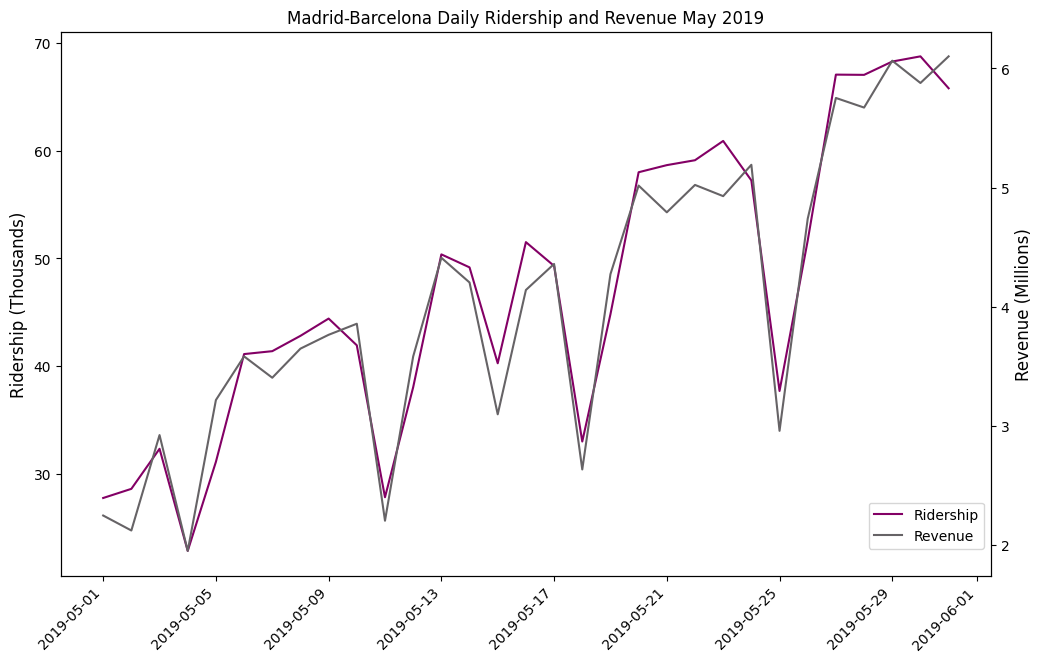

In [9]:
train_summary = (train.groupby(train['departure'].dt.date)
                 .agg(ridership=('price','count'),
                      total_fare=("price", 'sum'),
                      )
                 ).reset_index()
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Madrid-Barcelona Daily Ridership and Revenue May 2019")
ax.plot(train_summary["departure"],
        train_summary["ridership"] / 1000, #Display in K
        c="#830065",
        label="Ridership"
       )
ax.set_ylabel("Ridership (Thousands)",fontsize=12)
ax2 = ax.twinx()
ax2.plot(train_summary["departure"],
         train_summary["total_fare"] / 1000000, #Display in Millions
         c="#666366",
         label="Revenue"
        )
ax2.set_ylabel("Revenue (Millions)",fontsize=12)
fig.autofmt_xdate(rotation=45)
fig.legend(bbox_to_anchor=(.9,.3))
plt.show()


## Task 5: Daily Ridership Chart

Build a bar chart of average ridership by day of week and departure location to visualize this. Determine if one route is always busier or if it depends on the weekday. 

The x-axis of the bar chart should be the weekday, the y-axis should be ridership volume (count of rows for each departure/day of week combination), and there should be two bars representing the ridership for Madrid and Barcelona for each weekday. Consider using seaborn's barchart function to achieve this. 

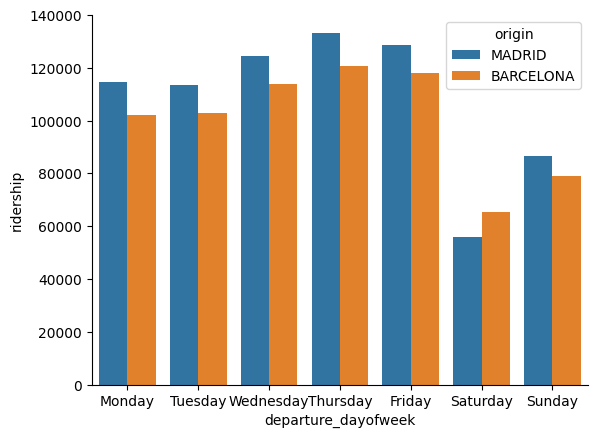

In [11]:
# Group the DataFrame by departure_dayofweek and origin.
weekly_ridership = (train.groupby(['departure_dayofweek','origin'], observed=False)
# Calculate the count of rows for each day of week and departure combination, using .groupby(), and .agg().
                    .agg(ridership=('price','count'))
# Then, reset the DataFrame index with reset_index(), which will make selecting the necessary columns for plotting a bit easier.
                    ).reset_index()
sns.barplot(x='departure_dayofweek', y='ridership',hue='origin', data=weekly_ridership)
sns.despine()
plt.show()

## Task 6: Info for Customer Help Site

It's time to produce the customer facing information to help them better plan their trips. We need to do the following task:

* Build two bar charts: Average price by vehicle_category and average duration by vehicle category. This will give our customers a good idea of the tradeoffs in time and cost for high-speed vs. standard trains.

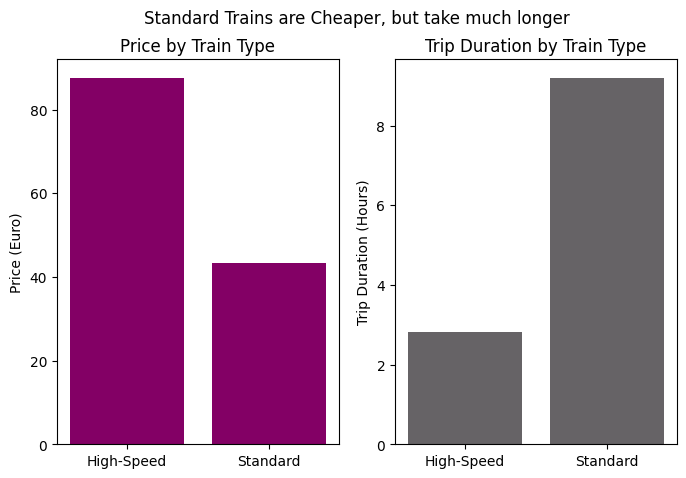

In [12]:
train_summary = (
    train.groupby('vehicle_category')
    .agg(
        average_fare=("price", 'mean'),
        average_duration=('duration', 'mean')
    )
)
fig, ax = plt.subplots(1,2,figsize=(8,5))
fig.suptitle("Standard Trains are Cheaper, but take much longer")
ax[0].bar(
    x=train_summary.index,
    height=train_summary['average_fare'],
    color = '#830065',
)
ax[0].set_title("Price by Train Type")
ax[0].set_ylabel("Price (Euro)")

# Average duration by vehicle category.

ax[1].bar(
    x=train_summary.index,
    height=train_summary['average_duration'],
    color = '#666366',
)
ax[1].set_title("Trip Duration by Train Type")
ax[1].set_ylabel("Trip Duration (Hours)")
plt.show()

## Task 7: Build a Heatmap and Export Summary Table

Build a heatmap of average price with day of week as columns and time of day as rows. Use it to determine which days and departure times have the lowest prices. Then, export the summary table used to build the heatmap to a flat file format of your choice. This will serve as a prototype for our designers to start building the customer help page.


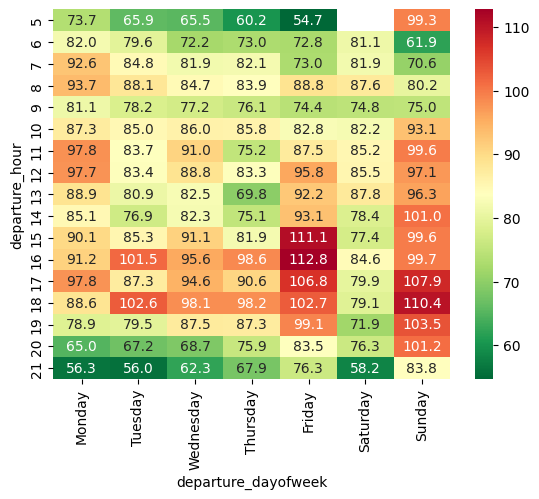

In [13]:
heatmap = train.pivot_table(index='departure_hour',
                            columns='departure_dayofweek',
                            values='price',
                            aggfunc='mean',
                            observed=False
                            )
sns.heatmap(data=heatmap,annot=True,fmt=".1f",cmap="RdYlGn_r")
plt.show()

In [14]:
heatmap.to_excel("price_heatmap.xlsx")